In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
from skimage import io
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

from radiomics import featureextractor  # This module is used for interaction with pyradiomics
import radiomics
import SimpleITK as sitk
import pkgutil
import xlsxwriter
from PIL import Image

%matplotlib inline

# Helpers

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
        
def read_nuclei(path):
    "Read raw data"

    # Load 4-channel image
    if len(path) == 0:
        return None
    
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    
    
    
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }

# MoNuSAC
# 1) Epithelial
# 2) Lymphocyte
# 3) Macrophage
# 4) Neutrophil

In [2]:
# Root directory of the project

width, height = 256,256
patch_size = (128, 128)
# step = 150
step = 200


print('\nSelect Organ')
option_Organ = int(input("\n 1-Breast \n 2-Kidney \n 3-Lung \n 4-Prostate \n"))
while option_Organ  not in (1,2,3,4,5):
    option_Organ = int(input("\n 1-Breast \n 2-Kidney \n 3-Lung \n 4-Prostate \n"))

if option_Organ==1:
    Organ = "Breast/"
elif option_Organ==2:
    Organ = "Kidney/"
elif option_Organ==3:
    Organ = "Lung/"
elif option_Organ==4:
    Organ = "Prostate/"
    
        
data_folder_R = "D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/"

Mode = "Train"
ROOT_DIR = "D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/"
ROOT_DIR_ = "D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data_Classwise_" + str(patch_size[0]) + "_" + str(step)


# Mode = "Test"
# ROOT_DIR = "D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Testing_Data/"
# ROOT_DIR_ = "D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Testing_Data_Classwise_" + str(patch_size[0]) + "_" + str(step)


# Training file directory
IMAGES_FOLDER = os.path.join(ROOT_DIR, "Images_&_Annotations_Organ/" + str(Organ))
MASKS_FOLDER = os.path.join(ROOT_DIR, "Masks_Organ/" + str(Organ))


Folder_N = "Data_Processed/"

IMAGES_DEST =  os.path.join(ROOT_DIR, Folder_N, str(Organ), "Images/")
MASKS_DEST = os.path.join(ROOT_DIR, Folder_N, str(Organ), "Masks/")

try:
    # Make directory
    create_directory(IMAGES_DEST)
except OSError:
    print ("Creation of the mask directory %s failed" % IMAGES_DEST)
    

try:
    # Make directory
    create_directory(MASKS_DEST)
except OSError:
    print ("Creation of the mask directory %s failed" % MASKS_DEST)



Folder1 = "Data_Patches"
Folder2 = "Data_Split"

IMAGES_DEST_v1 =  os.path.join(ROOT_DIR_, Folder1, str(Organ), "Images/")
MASKS_DEST_v1 = os.path.join(ROOT_DIR_, Folder1, str(Organ), "Masks/")

# Make new folders
try:
    # Make directory
    create_directory(IMAGES_DEST_v1)
except OSError:
    print ("Creation of the mask directory %s failed" % IMAGES_DEST_v1)


try:
    # Make directory
    create_directory(MASKS_DEST_v1)
except OSError:
    print ("Creation of the mask directory %s failed" % MASKS_DEST_v1)
    

## Split data_patches into patch level train valFolder1"Data_Patches") # sliding window patches
IN_FOLDER = os.path.join(ROOT_DIR_, Folder1, str(Organ)) # sliding window patches
OUT_FOLDER = os.path.join(ROOT_DIR_, Folder2, str(Organ))

    
print('\n')
print('---'*35)
print('Main Folders')

print(ROOT_DIR)
print(IMAGES_DEST)
print(MASKS_DEST)

print(IMAGES_DEST_v1)
print(MASKS_DEST_v1)

print('---'*35)



Select Organ

 1-Breast 
 2-Kidney 
 3-Lung 
 4-Prostate 
4


---------------------------------------------------------------------------------------------------------
Main Folders
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Data_Processed/Prostate/Images/
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Data_Processed/Prostate/Masks/
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data_Classwise_128_200\Data_Patches\Prostate/Images/
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data_Classwise_128_200\Data_Patches\Prostate/Masks/
---------------------------------------------------------------------------------------------------------


In [3]:
print('---'*35)
print('Images Folder')

IMAGES_SUB_FOLDER = [os.path.join(IMAGES_FOLDER, i) for i in sorted(next(os.walk(IMAGES_FOLDER))[1])]
print(IMAGES_SUB_FOLDER[:5])
print("Total Images: ", len(IMAGES_SUB_FOLDER[:]))

print('\n')
print('---'*35)
print('Masks Folder')

MASKS_SUB_FOLDER = [os.path.join(MASKS_FOLDER, i) for i in sorted(next(os.walk(MASKS_FOLDER))[1])]
print(MASKS_SUB_FOLDER[:5])
print("Total Masks: ", len(MASKS_SUB_FOLDER[:]))

print('---'*35)

---------------------------------------------------------------------------------------------------------
Images Folder
['D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-EJ-5505-01Z-00-DX1', 'D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1', 'D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-G9-6342-01Z-00-DX1', 'D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-J4-A67T-01Z-00-DX1', 'D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-KK-A59X-01Z-00-DX1']
Total Images:  6


---------------------------------------------------------------------------------------------------------
Masks Folder
['D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select

In [5]:
def resize_image(image, width, height):

    dim = (width, height)
    # resize image
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    return image



def pad(img, pad_size=96):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 80 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)



def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells



def extract_patches_N(image, step, patch_size):
    
    patches = []
    
    # Get locations
    x_pos, y_pos, cells = sliding_window(image, step, (patch_size[0], patch_size[1]))

    for (x, y, cell) in zip(x_pos, y_pos, cells):

        # Get patch
        patch = image[y:y + patch_size[0], x:x + patch_size[0]]

        # Get size
        raw_dim = (patch.shape[1], patch.shape[0]) # W, H

        if raw_dim != (patch_size[0], patch_size[1]):

            patch, pad_locs = pad(patch, pad_size=patch_size[0])
            patches.append(patch)
        
        else:

            patches.append(patch)
    
    patches = np.array(patches)
    
    return patches




In [9]:
def sub_class_process(img, all_mask_sub_dir_temp, mask_sub_path, MASKS_DEST, M_No, patch_size, step, MASK_NO, Organ):

    if Organ == "Breast/":
        print(Organ)
    elif Organ == "Kidney/":
        print(Organ)
    elif Organ == "Lung/":
        print(Organ)
    elif Organ == "Prostate/":
        print(Organ)

    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
    
    # Go to each sub folder
    # Read the 4 class folders
    class_sub_dir = sorted(glob(all_mask_sub_dir_temp + '/*'))  
    
    img = resize_image(img, width, height)
    
    # For each class folder get the mask
    for i in range(len(class_sub_dir)):
        
        # get the mask in the subfolder
        mask_paths = sorted(glob(class_sub_dir[i] + '/*.tif'))

        # If more than one mask present in folder(maybe not)
        # For each class folder: 1) read the mask 2) Convert to class label from the binary class label
        for j in range(len(mask_paths)):
            if i == 0:
                img_patches = None
                gt_patches = None
                epithelial_mask = None
                epithelial_mask_path = None
                
                print("\tSub-Image No:", j, ", Type Epithelial")
                print("\t {}". format(mask_paths[j]))
                epithelial_mask = read_nuclei(mask_paths[j])
                epithelial_mask = np.where(epithelial_mask==255.0, 1.0, epithelial_mask)
                epithelial_mask = epithelial_mask.astype(np.uint8)
                epithelial_mask = resize_image(epithelial_mask, width, height)
                
                save_nuclei(MASKS_DEST + "{}_{}_{}.png".format(M_No,MASK_NO,"E"), epithelial_mask)
                epithelial_mask_path = str(mask_sub_path) + ", "+ str(Organ.replace('/', " ")) + " " + str(j)  + ", Mask Type E"
                    
                if img is not None  and epithelial_mask is not None:
                    fig, axs = plt.subplots(1, 2, figsize=(8,8))
                    axs[0].imshow(img)
                    axs[0].set_title("WSI")
                    axs[0].axis('off')

                    axs[1].imshow(epithelial_mask, cmap=map_name, norm=norm)
                    axs[1].set_title(epithelial_mask_path)
                    axs[1].axis('off')

                    plt.tight_layout()
                    plt.show()
        
                if epithelial_mask is not None:
                    img_patches = extract_patches_N(img, step, patch_size)
                    gt_patches = extract_patches_N(epithelial_mask, step, patch_size)

                    print('\tImage Shape: {}'.format(img.shape))
                    print('\tGT Shape: {}'.format(epithelial_mask.shape))

                    print('\tImage Patch Shape: {}'.format(img_patches.shape))
                    print('\tGT Patch Shape: {}'.format(gt_patches.shape))

                    # Iterate over all image and masks
                    count_E=0
                    for im, msk in zip(img_patches, gt_patches):
                        if np.mean(msk) > 0.0005:
                            # Save image patch 
                            save_nuclei(IMAGES_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"E",count_E), im)
                            # Save mask patch
                            save_nuclei(MASKS_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"E",count_E), msk)
                            count_E+=1
                        else:
                            pass

                    im = None
                    msk = None
                    img_patches = None
                    gt_patches = None
                    epithelial_mask = None
                    epithelial_mask_path = None

                    
                    
                    
                    
            elif i == 1:
                img_patches = None
                gt_patches = None
                lymphocyte_mask = None
                lymphocyte_mask_path = None
                
                print("\tSub-Image No:", j, ", Type Lymphocyte")
                print("\t {}". format(mask_paths[j]))
                lymphocyte_mask = read_nuclei(mask_paths[j])
                lymphocyte_mask = np.where(lymphocyte_mask==255.0, 2.0, lymphocyte_mask)
                lymphocyte_mask = lymphocyte_mask.astype(np.uint8)
                lymphocyte_mask = resize_image(lymphocyte_mask, width, height)
                
                save_nuclei(MASKS_DEST + "{}_{}_{}.png".format(M_No,MASK_NO,"L"),  lymphocyte_mask)
                lymphocyte_mask_path = str(mask_sub_path) + ", "+ str(Organ.replace('/', " ")) + " " + str(j)  + ", Mask Type L"
                
                if img is not None  and lymphocyte_mask is not None:
                    fig, axs = plt.subplots(1, 2, figsize=(8,8))
                    axs[0].imshow(img)
                    axs[0].set_title("WSI")
                    axs[0].axis('off')

                    axs[1].imshow(lymphocyte_mask, cmap=map_name, norm=norm)
                    axs[1].set_title(lymphocyte_mask_path)
                    axs[1].axis('off')

                    plt.tight_layout()
                    
                if lymphocyte_mask is not None:
                    img_patches = extract_patches_N(img, step, patch_size)
                    gt_patches = extract_patches_N(lymphocyte_mask, step, patch_size)

                    print('\tImage Shape: {}'.format(img.shape))
                    print('\tGT Shape: {}'.format(lymphocyte_mask.shape))

                    print('\tImage Patch Shape: {}'.format(img_patches.shape))
                    print('\tGT Patch Shape: {}'.format(gt_patches.shape))

                    # Iterate over all image and masks
                    count_L=0
                    for im, msk in zip(img_patches, gt_patches):
                        if np.mean(msk) > 0.0005:
                            # Save image patch 
                            save_nuclei(IMAGES_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"L",count_L), im)
                            # Save mask patch
                            save_nuclei(MASKS_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"L",count_L), msk)
                            count_L+=1
                        else:
                            pass

                    im = None
                    msk = None
                    img_patches = None
                    gt_patches = None
                    lymphocyte_mask = None
                    lymphocyte_mask_path = None

                    
                    
                    
                    
            elif i == 2:
                img_patches = None
                gt_patches = None
                macrophage_mask = None
                macrophage_mask_path = None
                
                print("\tSub-Image No:", j, ", Type Macrophage")
                print("\t {}". format(mask_paths[j]))
                macrophage_mask = read_nuclei(mask_paths[j])
                macrophage_mask = np.where(macrophage_mask==255.0, 3.0, macrophage_mask)
                macrophage_mask = macrophage_mask.astype(np.uint8)
                macrophage_mask = resize_image(macrophage_mask, width, height)
                
                save_nuclei(MASKS_DEST + "{}_{}_{}.png".format(M_No,MASK_NO,"M"), macrophage_mask)
                macrophage_mask_path = str(mask_sub_path) + ", "+ str(Organ.replace('/', " ")) + " " + str(j)  + ", Mask Type M"
                
                if img is not None  and macrophage_mask is not None:
                    fig, axs = plt.subplots(1, 2, figsize=(8,8))
                    axs[0].imshow(img)
                    axs[0].set_title("WSI")
                    axs[0].axis('off')

                    axs[1].imshow(macrophage_mask, cmap=map_name, norm=norm)
                    axs[1].set_title(macrophage_mask_path)
                    axs[1].axis('off')

                    plt.tight_layout()
                    plt.show()
                    
                if macrophage_mask is not None:
                    img_patches = extract_patches_N(img, step, patch_size)
                    gt_patches = extract_patches_N(macrophage_mask, step, patch_size)

                    print('\tImage Shape: {}'.format(img.shape))
                    print('\tGT Shape: {}'.format(macrophage_mask.shape))

                    print('\tImage Patch Shape: {}'.format(img_patches.shape))
                    print('\tGT Patch Shape: {}'.format(gt_patches.shape))

                    # Iterate over all image and masks
                    count_M=0
                    for im, msk in zip(img_patches, gt_patches):
                        if np.mean(msk) > 0.0005:
                            # Save image patch 
                            save_nuclei(IMAGES_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"M",count_M), im)
                            # Save mask patch
                            save_nuclei(MASKS_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"M",count_M), msk)
                            count_M+=1
                        else:
                            pass

                    im = None
                    msk = None
                    img_patches = None
                    gt_patches = None
                    macrophage_mask = None
                    macrophage_mask_path = None

                    
                    
                    
                    
            elif i == 3:
                img_patches = None
                gt_patches = None
                neutrophil_mask = None
                neutrophil_mask_path = None
                
                
                print("\tSub-Image No:", j, ", Type Neutrophil")
                print("\t {}". format(mask_paths[j]))
                neutrophil_mask = read_nuclei(mask_paths[j])
                neutrophil_mask = np.where(neutrophil_mask==255.0, 4.0, neutrophil_mask)
                neutrophil_mask = neutrophil_mask.astype(np.uint8)
                neutrophil_mask = resize_image(neutrophil_mask, width, height)
                
                save_nuclei(MASKS_DEST + "{}_{}_{}.png".format(M_No,MASK_NO,"N"), neutrophil_mask)
                neutrophil_mask_path = str(mask_sub_path) + ", "+ str(Organ.replace('/', " ")) + " " + str(j)  + ", Mask Type N"
                
                if img is not None  and neutrophil_mask is not None:
                    fig, axs = plt.subplots(1, 2, figsize=(8,8))
                    axs[0].imshow(img)
                    axs[0].set_title("WSI")
                    axs[0].axis('off')

                    axs[1].imshow(neutrophil_mask, cmap=map_name, norm=norm)
                    axs[1].set_title(neutrophil_mask_path)
                    axs[1].axis('off')

                    plt.tight_layout()
                    plt.show()
                    
                if neutrophil_mask is not None:
                    img_patches = extract_patches_N(img, step, patch_size)
                    gt_patches = extract_patches_N(neutrophil_mask, step, patch_size)

                    print('\tImage Shape: {}'.format(img.shape))
                    print('\tGT Shape: {}'.format(neutrophil_mask.shape))

                    print('\tImage Patch Shape: {}'.format(img_patches.shape))
                    print('\tGT Patch Shape: {}'.format(gt_patches.shape))

                    # Iterate over all image and masks
                    count_N=0
                    for im, msk in zip(img_patches, gt_patches):
                        if np.mean(msk) > 0.0005:
                            # Save image patch 
                            save_nuclei(IMAGES_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"N",count_N), im)
                            # Save mask patch
                            save_nuclei(MASKS_DEST_v1 + "Image-{}_Mask-{}_Type-{}_PatchNo-{}.png".format(M_No,MASK_NO,"N",count_N), msk)
                        else:
                            pass

                    im = None
                    msk = None
                    img_patches = None
                    gt_patches = None
                    neutrophil_mask = None
                    neutrophil_mask_path = None





In [11]:
def masks_Count(img, all_mask_sub_dir, MASKS_SUB_FOLDER, count, patch_size_, step_, Organ):

    count_mask = 0
    
    for j in range(len(all_mask_sub_dir)):

        mask_sub_path = os.path.split(MASKS_SUB_FOLDER)[1]

        #### Train #### 
        if Mode=="Train":

            #### Breast #### 
            if Organ=="Breast/":

                if mask_sub_path=="TCGA-A2-A0CV-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-A2-A0ES-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-B6-A0WZ-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-BH-A18T-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-D8-A1X5-01Z-00-DX2":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-E2-A154-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-E9-A22B-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-E9-A22G-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-EW-A6SD-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-S3-AA11-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-A2-A0ES-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-A2-A04X-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-D8-A3Z6-01Z-00-DX2":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-E2-A108-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-EW-A6SB-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)



            #### Kidney #### 
            if Organ=="Kidney/":

                if mask_sub_path=="TCGA-5P-A9K0-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-B9-A8YI-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-B9-A44B-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-DW-7841-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-EV-5903-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-F9-A97G-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-G7-A8LD-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-MH-A560-01Z-00-DX2":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-P4-AAVK-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-SX-A7SR-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-UZ-A9PO-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-UZ-A9PU-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-2Z-A9JG-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-2Z-A9JN-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-DW-7838-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-DW-7963-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-F9-A8NY-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-IZ-A6M9-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-MH-A55W-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)



            #### Lung #### 
            if Organ=="Lung/":

                if mask_sub_path=="TCGA-55-1594-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-69-7760-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-69-A59K-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-73-4668-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-78-7220-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-86-7713-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-86-8672-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-L4-A4E5-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-MP-A4SY-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-MP-A4T7-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-49-6743-01Z-00-DX2":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-50-6591-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-55-7570-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-55-7573-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-73-4662-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-78-7152-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-MP-A4T7-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)



            #### Prostate #### 
            if Organ=="Prostate/":

                if mask_sub_path=="TCGA-EJ-5495-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-EJ-5505-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-EJ-5517-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-G9-6342-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-G9-6499-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-J4-A67Q-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-J4-A67T-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-KK-A6E0-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-KK-A7AW-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-KK-A59X-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-V1-A8WL-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-V1-A9O9-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-X4-A8KQ-01Z-00-DX8":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-YL-A9WY-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-G9-6356-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-G9-6367-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-VP-A87E-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-VP-A87H-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-X4-A8KS-01Z-00-DX3":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


                if mask_sub_path=="TCGA-YL-A9WL-01Z-00-DX1":
                    print("\n\nMask No:", j)
                    print(all_mask_sub_dir[j])
                    sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)



In [14]:
def masks_Count(img, all_mask_sub_dir, MASKS_SUB_FOLDER, count, patch_size_, step_, Organ):

    count_mask = 0
    
    for j in range(len(all_mask_sub_dir)):

        mask_sub_path = os.path.split(MASKS_SUB_FOLDER)[1]

        #### Train #### 
        if Mode=="Train":

            #### Breast ####
            if Organ=="Breast/":
                print("\n\nMask No:", j)
                print(all_mask_sub_dir[j])
                sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


            #### Kidney #### 
            if Organ=="Kidney/":
                print("\n\nMask No:", j)
                print(all_mask_sub_dir[j])
                sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


            #### Lung #### 
            if Organ=="Lung/":
                print("\n\nMask No:", j)
                print(all_mask_sub_dir[j])
                sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)


            #### Prostate #### 
            if Organ=="Prostate/":
                print("\n\nMask No:", j)
                print(all_mask_sub_dir[j])
                sub_class_process(img, all_mask_sub_dir[j], mask_sub_path, MASKS_DEST, count, patch_size_, step_, count_mask, Organ)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]






 Image No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-EJ-5505-01Z-00-DX1\TCGA-EJ-5505-01Z-00-DX1-4.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5505-01Z-00-DX1\TCGA-EJ-5505-01Z-00-DX1-4
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5505-01Z-00-DX1\TCGA-EJ-5505-01Z-00-DX1-4\Epithelial\375_mask.tif


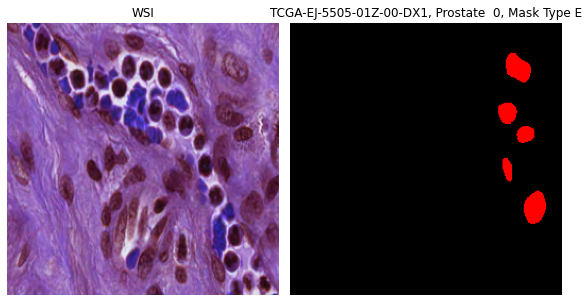

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5505-01Z-00-DX1\TCGA-EJ-5505-01Z-00-DX1-4\Lymphocyte\376_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5505-01Z-00-DX1\TCGA-EJ-5505-01Z-00-DX1-4\Neutrophil\377_mask.tif


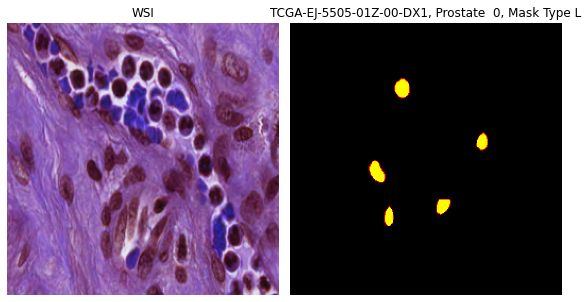

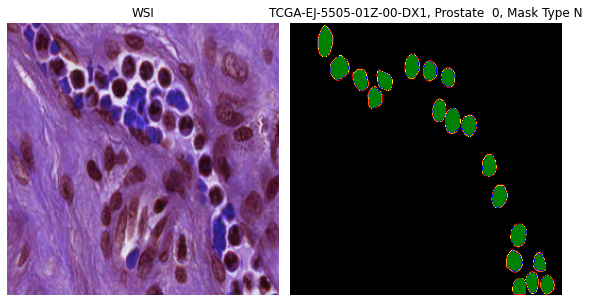

 17%|██████████████                                                                      | 1/6 [00:00<00:03,  1.41it/s]

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
0







 Image No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1\Epithelial\388_mask.tif


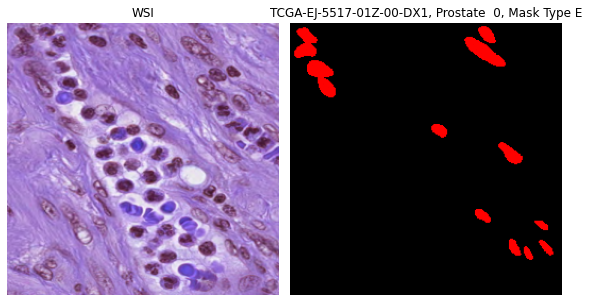

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1\Lymphocyte\389_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1\Neutrophil\387_mask.tif


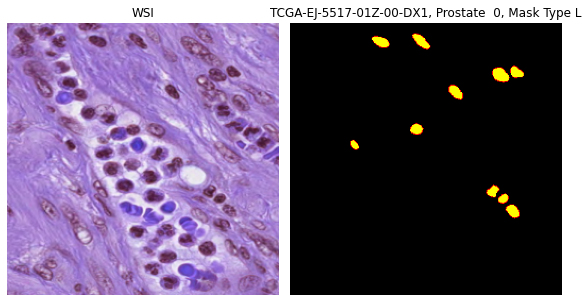

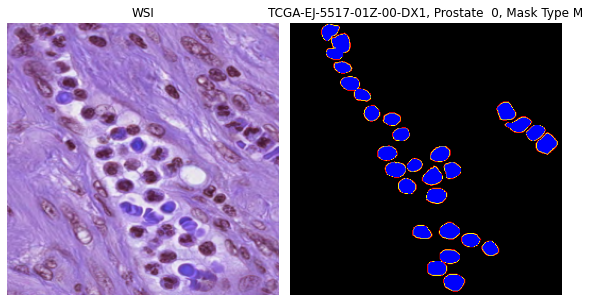

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
2


Mask No: 1
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4\Epithelial\392_mask.tif


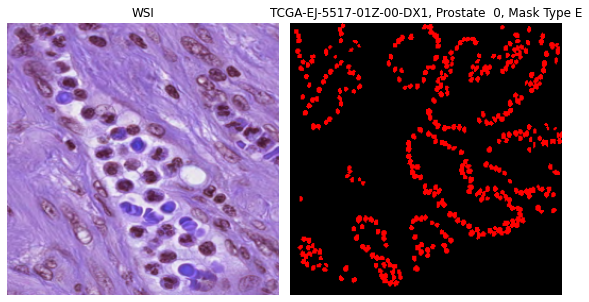

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4\Lymphocyte\393_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
2
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4\Neutrophil\394_mask.tif


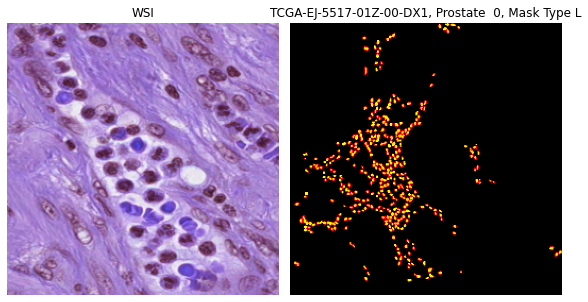

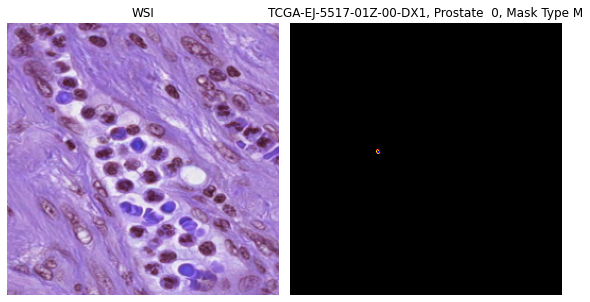

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0





 Image No: 1
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1\Epithelial\388_mask.tif


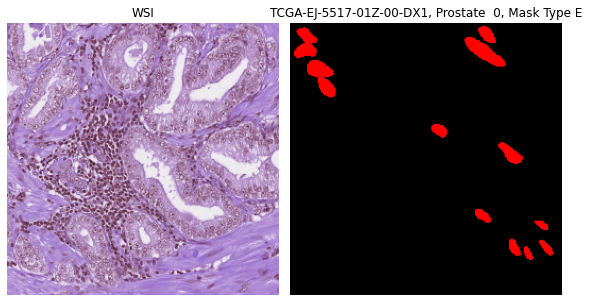

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1\Lymphocyte\389_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-1\Neutrophil\387_mask.tif


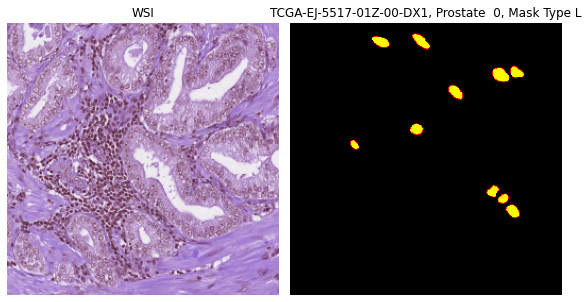

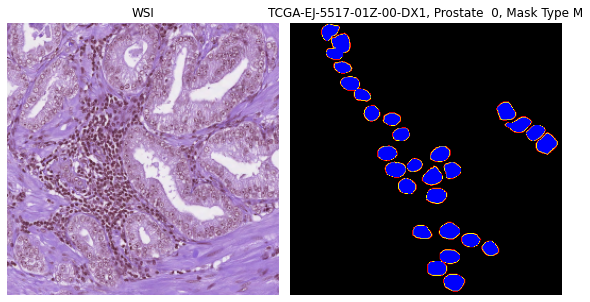

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
2


Mask No: 1
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4\Epithelial\392_mask.tif


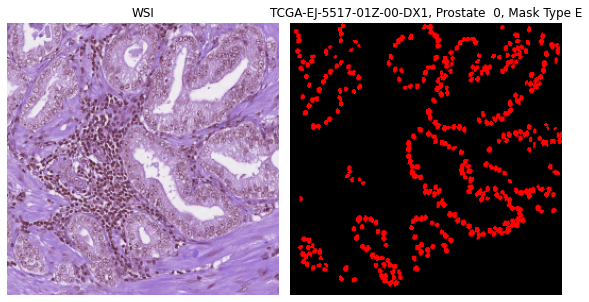

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4\Lymphocyte\393_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
2
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-EJ-5517-01Z-00-DX1\TCGA-EJ-5517-01Z-00-DX1-4\Neutrophil\394_mask.tif


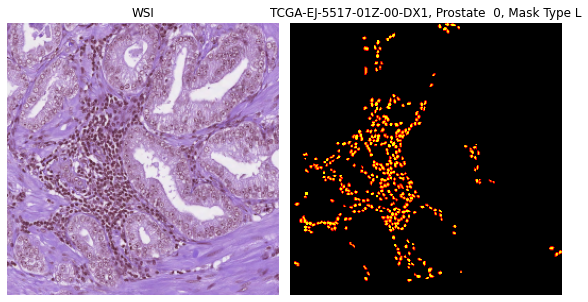

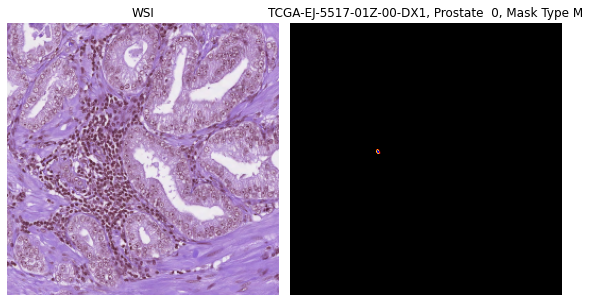

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0


 33%|████████████████████████████                                                        | 2/6 [00:05<00:12,  3.01s/it]








 Image No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-G9-6342-01Z-00-DX1\TCGA-G9-6342-01Z-00-DX1-2.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-G9-6342-01Z-00-DX1\TCGA-G9-6342-01Z-00-DX1-2
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-G9-6342-01Z-00-DX1\TCGA-G9-6342-01Z-00-DX1-2\Epithelial\495_mask.tif


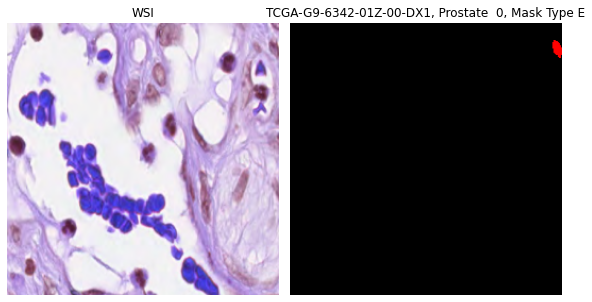

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-G9-6342-01Z-00-DX1\TCGA-G9-6342-01Z-00-DX1-2\Lymphocyte\496_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-G9-6342-01Z-00-DX1\TCGA-G9-6342-01Z-00-DX1-2\Neutrophil\497_mask.tif


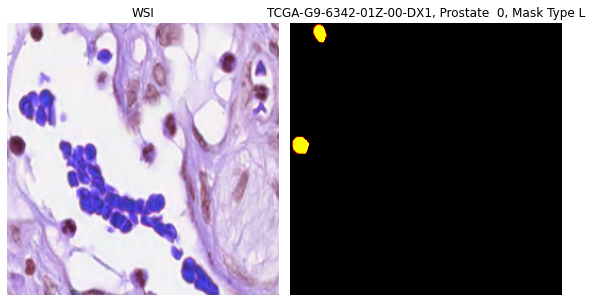

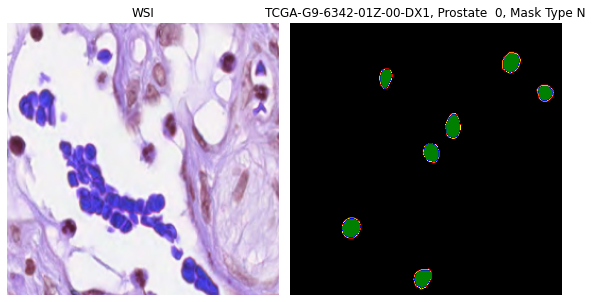

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
0
0


 50%|██████████████████████████████████████████                                          | 3/6 [00:06<00:06,  2.04s/it]








 Image No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-J4-A67T-01Z-00-DX1\TCGA-J4-A67T-01Z-00-DX1-2.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-J4-A67T-01Z-00-DX1\TCGA-J4-A67T-01Z-00-DX1-2
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-J4-A67T-01Z-00-DX1\TCGA-J4-A67T-01Z-00-DX1-2\Epithelial\531_mask.tif


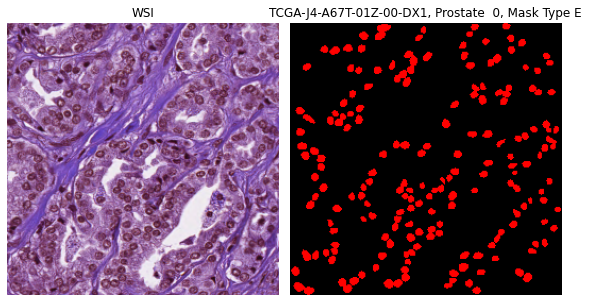

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-J4-A67T-01Z-00-DX1\TCGA-J4-A67T-01Z-00-DX1-2\Lymphocyte\532_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-J4-A67T-01Z-00-DX1\TCGA-J4-A67T-01Z-00-DX1-2\Macrophage\534_mask.tif


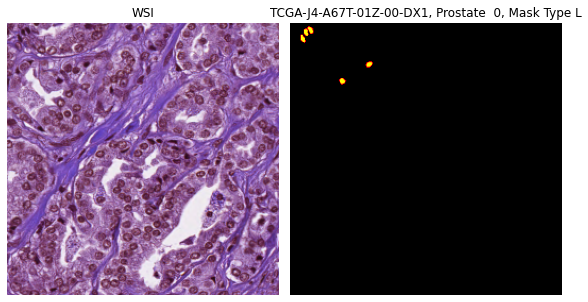

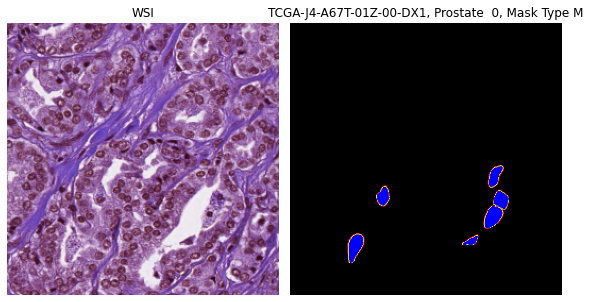

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:07<00:03,  1.61s/it]








 Image No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-KK-A59X-01Z-00-DX1\TCGA-KK-A59X-01Z-00-DX1-3.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-KK-A59X-01Z-00-DX1\TCGA-KK-A59X-01Z-00-DX1-3
Prostate/
	Sub-Image No: 0 , Type Epithelial
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-KK-A59X-01Z-00-DX1\TCGA-KK-A59X-01Z-00-DX1-3\Epithelial\559_mask.tif


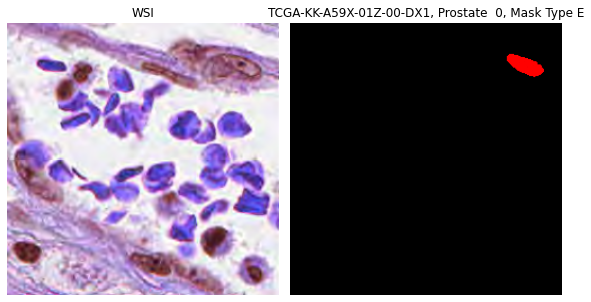

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-KK-A59X-01Z-00-DX1\TCGA-KK-A59X-01Z-00-DX1-3\Lymphocyte\560_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-KK-A59X-01Z-00-DX1\TCGA-KK-A59X-01Z-00-DX1-3\Neutrophil\561_mask.tif


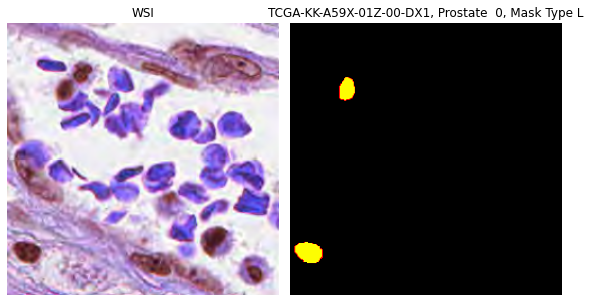

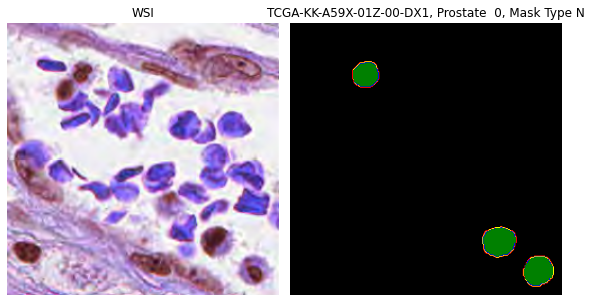

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.26s/it]

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
0







 Image No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4
Prostate/
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4\Lymphocyte\768_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4\Macrophage\770

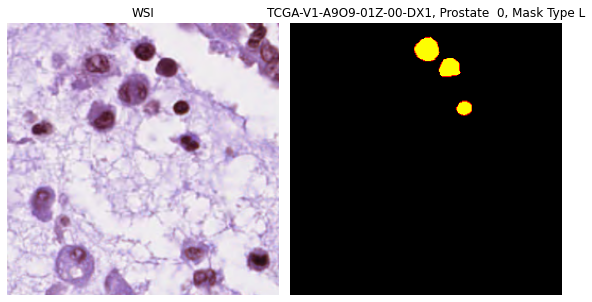

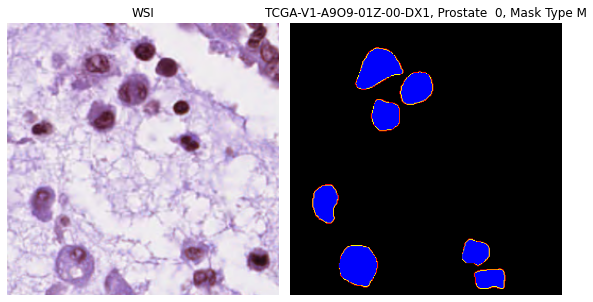

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
2
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4\Neutrophil\769_mask.tif


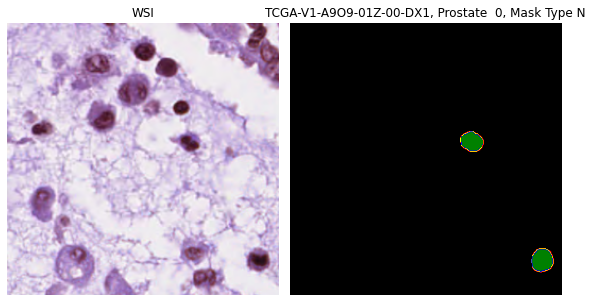

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0


Mask No: 1
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5
Prostate/
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5\Lymphocyte\772_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5\Macrophage\774_mask.tif


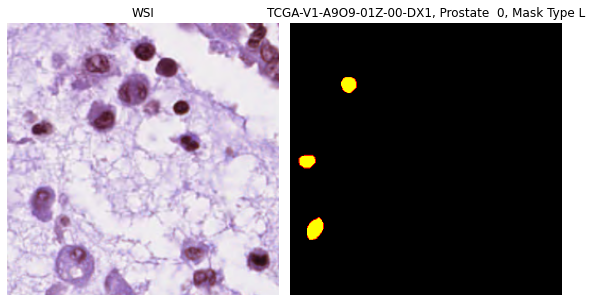

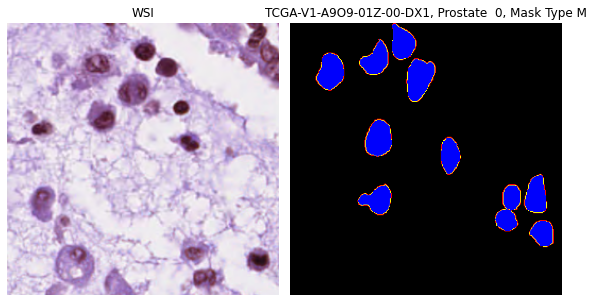

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5\Neutrophil\773_mask.tif


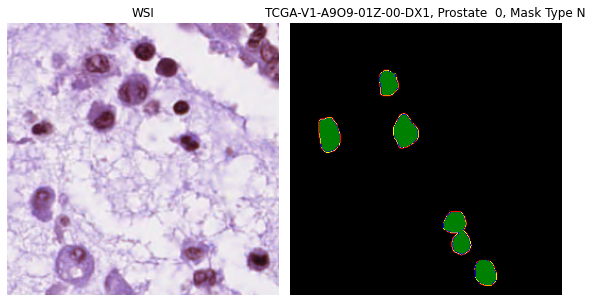

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0





 Image No: 1
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Images_&_Annotations_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5.tif


Mask No: 0
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4
Prostate/
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4\Lymphocyte\768_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4\Macrophage\770_mas

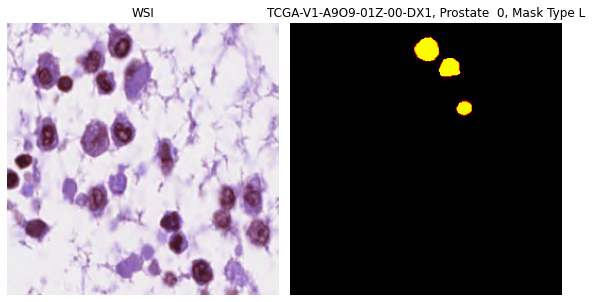

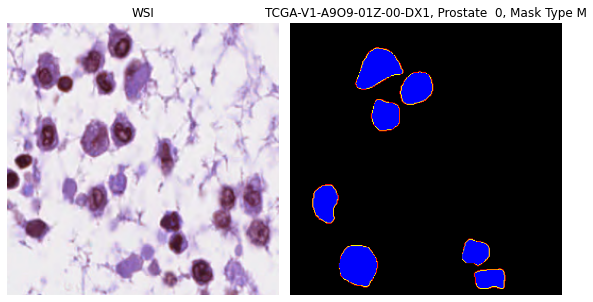

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
2
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-4\Neutrophil\769_mask.tif


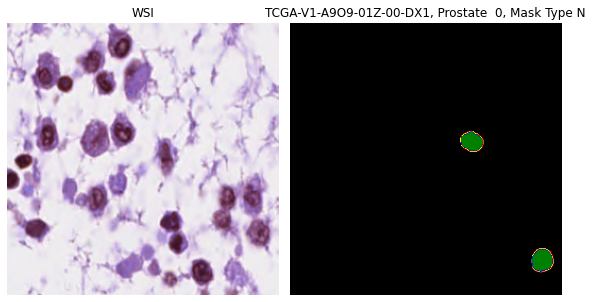

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0


Mask No: 1
D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5
Prostate/
	Sub-Image No: 0 , Type Lymphocyte
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5\Lymphocyte\772_mask.tif
	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Macrophage
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5\Macrophage\774_mask.tif


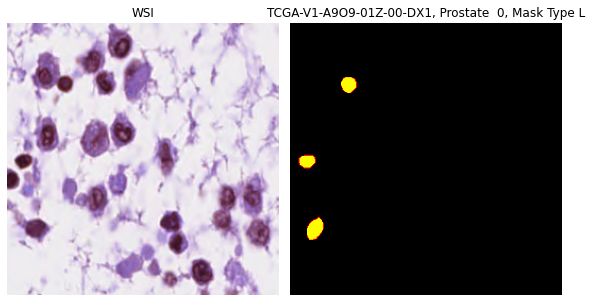

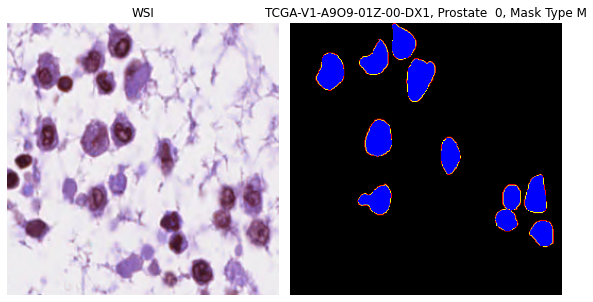

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0
1
	Sub-Image No: 0 , Type Neutrophil
	 D://Taimoor_Datasets/Thesis/Nuclei/MoNuSAC/Select_January_23/Training_Data/Masks_Organ/Prostate/TCGA-V1-A9O9-01Z-00-DX1\TCGA-V1-A9O9-01Z-00-DX1-5\Neutrophil\773_mask.tif


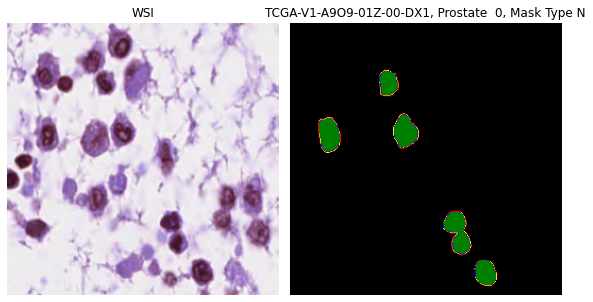

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.75s/it]

	Image Shape: (256, 256, 3)
	GT Shape: (256, 256)
	Image Patch Shape: (4, 128, 128, 3)
	GT Patch Shape: (4, 128, 128)
0



Count:  8
RAW CT Count:  8


In [15]:
### MAIN#########

images = []
masks = []

iterator = 0

count = 0

img = None
epithelial_mask = None
lymphocyte_mask = None
macrophage_mask = None
neutrophil_mask = None

raw_ct = 0
gt_ct = 0


for ct in tqdm(range(len(IMAGES_SUB_FOLDER[:]))):

    # Read all raw images in image sub folder
    all_imgs = sorted(glob(IMAGES_SUB_FOLDER[ct] + '/*.tif'))

    # Read the mask sub folders
    all_mask_sub_dir = sorted(glob(MASKS_SUB_FOLDER[ct]+ '/*'))

    # Iterate over the individual raw images
    for i in range(len(all_imgs)):

        image_sub_path = os.path.split(IMAGES_SUB_FOLDER[ct])[1]

        #### Train #### 
        if Mode=="Train":

            #### Breast #### 
            if Organ=="Breast/":
                print("\n\n\n\n\n Image No:", i)
                print(all_imgs[i])
                img = read_nuclei(all_imgs[i])
                masks_Count(img, all_mask_sub_dir, MASKS_SUB_FOLDER[ct], count, patch_size, step, Organ)
                count = count + 1

            #### Kidney #### 
            if Organ=="Kidney/":
                print("\n\n\n\n\n Image No:", i)
                print(all_imgs[i])
                img = read_nuclei(all_imgs[i])
                masks_Count(img, all_mask_sub_dir, MASKS_SUB_FOLDER[ct], count, patch_size, step, Organ)
                count = count + 1

            #### Lung #### 
            if Organ=="Lung/":
                print("\n\n\n\n\n Image No:", i)
                print(all_imgs[i])
                img = read_nuclei(all_imgs[i])
                masks_Count(img, all_mask_sub_dir, MASKS_SUB_FOLDER[ct], count, patch_size, step, Organ)
                count = count + 1

            #### Prostate #### 
            if Organ=="Prostate/":
                print("\n\n\n\n\n Image No:", i)
                print(all_imgs[i])
                img = read_nuclei(all_imgs[i])
                masks_Count(img, all_mask_sub_dir, MASKS_SUB_FOLDER[ct], count, patch_size, step, Organ)
                count = count + 1


        if img is not None:
            # Save it
            # .............

            save_nuclei(IMAGES_DEST+ "{}.png".format(raw_ct), img)
            raw_ct+=1
            
    #         Add to list
            images.append(img)
        
        img = None
    print("\n")


print("\nCount: ", count)
print("RAW CT Count: ", raw_ct)

count = 0
raw_ct = 0
count_mask = 0
gt_ct = 0
